In [1]:
import LOM
from sklearn.cross_validation import train_test_split
from sklearn import metrics

 /home/sudhanshu/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.


## Steps:
Generate three types of process through kernels:
- Gaussian -1
- Increasing/Decreasing linear trend
- Gaussian -2
- Generate latent process and a random phi add noise
- Label processes as coming from increasing trend-G1 as 1’s and decreasing trend-G1/G2 as 0’s
- Increasing C, check classification accuracy 
- Compare with Logistic regression and LDA: Stretch goal


In [3]:
## Linear increasing kernel
import GPy
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
kenrel = GPy.kern.Linear(1,variances=3)  * GPy.kern.Brownian(1,variance=2) 
kenrel = GPy.kern.Linear(1,variances=3) * GPy.kern.Brownian(1,variance=3) + GPy.kern.Matern52(1,variance=2,lengthscale=3) 
Matern1 = GPy.kern.PeriodicMatern32(1,lengthscale=3,variance=2)
Cosine1 = GPy.kern.Cosine(1,lengthscale=3,variance=2)
gaussian = GPy.kern.ExpQuad(1,lengthscale=3,variance=2)

In [26]:
def scale(d):
    return (d - d.min())/(d.max() - d.min())

def generatelatent(N,noiselevel=0.5):
    x = np.linspace(0,N-1,N)
    u1 = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=kenrel.K(x.reshape(N,1))) + noiselevel* np.random.normal(0,1,N)
    u2 = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=kenrel.K(x.reshape(N,1))) + noiselevel* np.random.normal(0,1,N)
    g1 = np.random.multivariate_normal(mean=np.ones(N).flatten(),cov=gaussian.K(x.reshape(N,1))) + noiselevel* np.random.normal(0,1,N)
    g2 = np.random.multivariate_normal(mean=np.ones(N).flatten(),cov=Cosine1.K(x.reshape(N,1))) + noiselevel*np.random.normal(0,1,N)
    return scale(u1),scale(u2),scale(g1),scale(g2)


Now we know our latent processes: g1,g2,increasingTrend,decreasingTrend
We sample phi and then combine these to generate data such that:
    - with probability 0.5:
        get g1 and increasing trend set Label to 1
     - With probability 0.5:
         get g1 or g2 with equal probability combine with decreasing trend and set label to -1
        

In [12]:
def generateData(W,phi,latents,S=100,C=3,P=2,N=100):
    #phi = np.random.normal(loc=0,scale=1,size=(C,P))
    P = len(latents) -1
    phiBar = np.matrix(np.kron(phi,np.eye(N)))
    B = np.ones(S)
    #W = np.random.rand(P*N)
    uBar = np.matrix(np.ones((S,N*P)))
    l = np.zeros(S)
    L = np.zeros(S)
    for s in range(S):
        if np.random.rand() < 0.4:
            L[s] = 1
            us = np.hstack([a for i,a in enumerate(latents) if i!=1 ])
        else:
            L[s] = -1
            us = np.hstack([a for i,a in enumerate(latents) if i!=0 ])
        uBar[s,:] = us
        l[s] = np.dot(uBar[s,:] ,W) + B[s]
        #L[s] = guessLabel(l[s])
    #print S,C,P,N
    #print "\n--",uBar.shape,phiBar.shape
    YBar = uBar * phiBar.T + np.random.normal(0,1)
    #print YBar.shape
    return YBar,L,uBar

### testing Infra:

## Testing the effect of C

In [29]:
Cs = range(1,10)
N = 100
actualP = 3
guessedP = 5
S= 200

ind = 0.8
accuracies = {}
f1Scores = {}
#latent = generatelatent(N=N)
for c in Cs:
    f1=[]
    accu=[]
    print "\n---\n C:",c
    W = np.random.rand(actualP*N)
    phi = np.random.normal(loc=0,scale=1,size=(c,actualP))
    for times in range(5):
        #generate data
        YBar,L,_ = generateData(W,phi,latents=latent,C=c,N=N,P=actualP,S=S)
        # create train test split
        Y_train, Y_test, L_train, L_test = train_test_split(YBar, L, test_size=0.4, random_state=0)
        # fit the model
        myModel = LOM.LOM(Y=Y_train,L=L_train,N=N,C=c,S=L_train.shape[0])
        myModel.fit(n=int(N*ind),iters=200,P=guessedP)
        # predict for test
        predictions,Expresults, _ = myModel.predict(Y_test)
        
        # calcualte accuracy
        print "Result:",np.unique(predictions,return_counts=True),np.unique(L_test,return_counts=True)
        f1.append(metrics.f1_score(y_pred=predictions,y_true=L_test))
        accu.append(metrics.accuracy_score(y_pred=predictions,y_true=L_test))
    print f1,"\n",accu
    f1Scores[c] = np.mean(f1)
    accuracies[c] = np.mean(accu)
#plt.plot(induction,results)


---
 C: 1
Concatenated Latent Gaussian Processes:
(500, 400) (400, 400) 0 20 40 60 80 100 120 140 160 180 Result: (array([-1.,  1.]), array([49, 31])) (array([-1.,  1.]), array([49, 31]))
Concatenated Latent Gaussian Processes:
(500, 400) (400, 400) 0 20 40 60 80 100 120 140 160 180 Result: (array([-1.,  1.]), array([40, 40])) (array([-1.,  1.]), array([40, 40]))
Concatenated Latent Gaussian Processes:
(500, 400) (400, 400) 0 20 40 60 80 100 120 140 160 180 Result: (array([-1.,  1.]), array([47, 33])) (array([-1.,  1.]), array([47, 33]))
Concatenated Latent Gaussian Processes:
(500, 400) (400, 400) 0 20 40 60 80 100 120 140 160 180 Result: (array([-1.,  1.]), array([45, 35])) (array([-1.,  1.]), array([45, 35]))
Concatenated Latent Gaussian Processes:
(500, 400) (400, 400) 0 20 40 60 80 100 120 140 160 180 Result: (array([ 1.]), array([80])) (array([-1.,  1.]), array([51, 29]))
[1.0, 1.0, 1.0, 1.0, 0.53211009174311918] 
[1.0, 1.0, 1.0, 1.0, 0.36249999999999999]

---
 C: 2
Concatenated

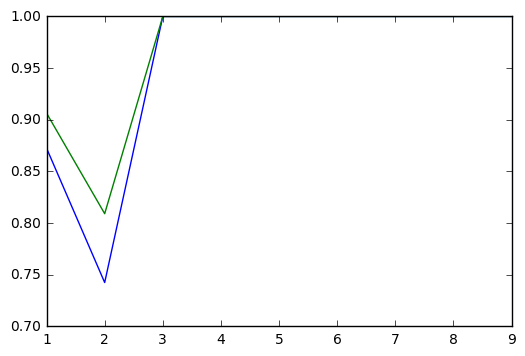

In [32]:
plt.plot(accuracies.keys(),accuracies.values())
plt.plot(f1Scores.keys(),f1Scores.values())

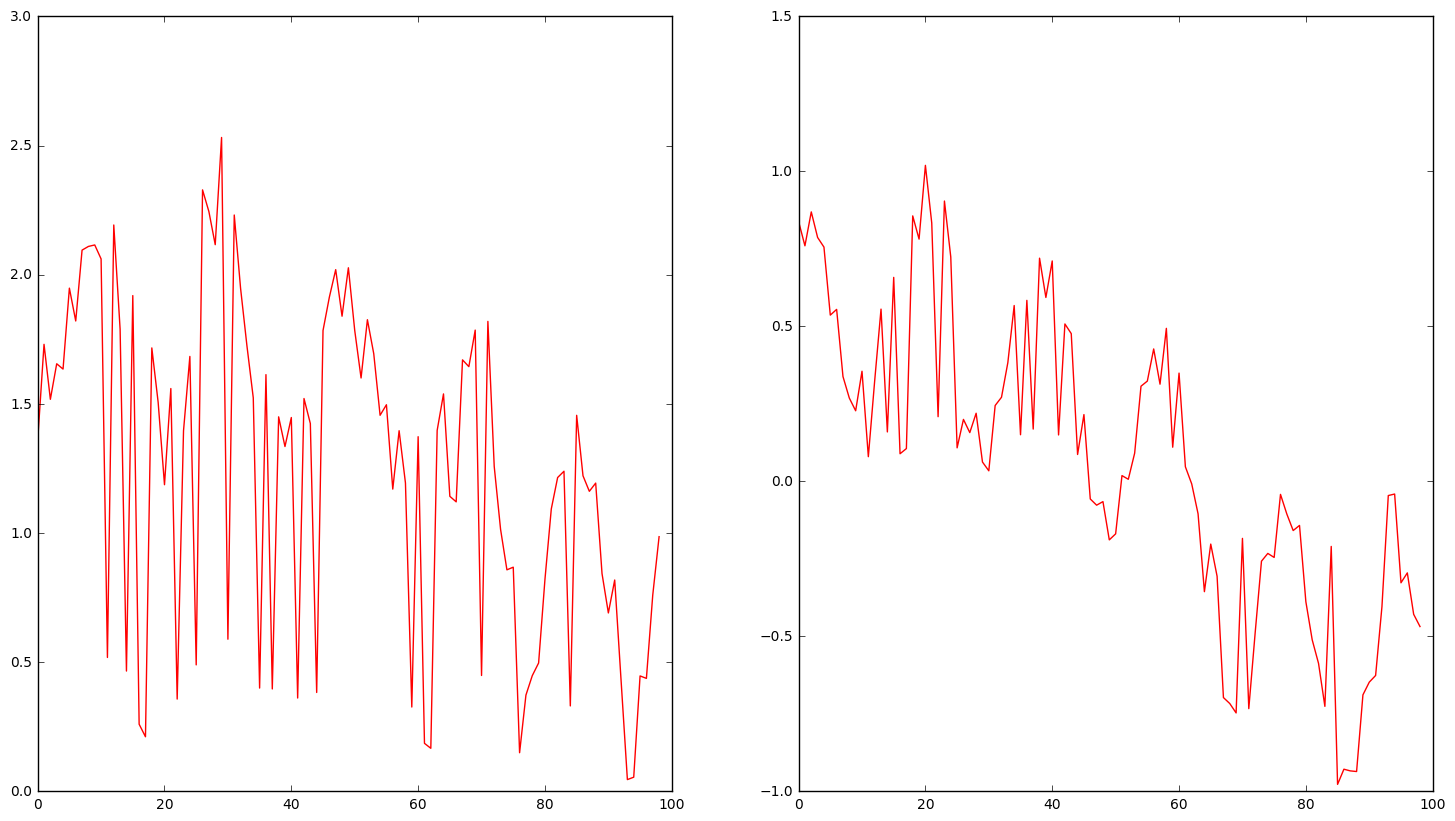

In [42]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(18,10))
p=0
axes[0].plot(myModel.uExpBar[0,p*N:p*N+N-1].T,c='r')
p=4
axes[1].plot(myModel.uExpBar[0,p*N:p*N+N-1].T,c='r')

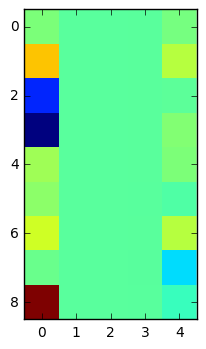

In [36]:
plt.imshow(myModel.phiHatExp,interpolation='None')

 /home/sudhanshu/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning:covariance is not positive-semidefinite.


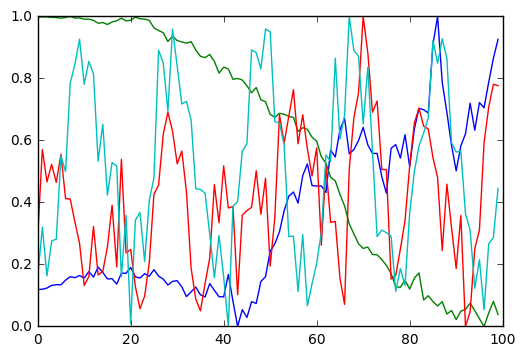

In [28]:
#latent = list(generatelatent(N=N))
for l in latent:
    plt.plot(l)

In [1]:
def plotLabel(YBar,L,S):
    for s in range(S):
        if L[s] < 0:
            plt.plot(YBar[s].T,c='r')
        else:
            plt.plot(YBar[s].T,c='b')
plotLabel(Y,L,S)

NameError: name 'Y' is not defined